In [1]:
IS_COLAB = False
DEV = False
EXP_DIR = "exp017"
if IS_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install -q pandas==2.0.3 recbole colorama ray kmeans_pytorch polars==0.15.16
    %cd /content/drive/MyDrive/signate/SMBC_tree/exp
    DATA_PATH = "/content/drive/MyDrive/signate/finance_2/input_data"
    OUTPUT_PATH = f"/Users/taichi/Library/CloudStorage/OneDrive-個人用/Documents/project/signate-finance-2/output"
else:
    %cd /Users/ogurayuudai/Library/CloudStorage/GoogleDrive-yudai.otahigh@gmail.com/マイドライブ/signate/SMBC_tree/exp
    DATA_PATH = "/Users/ogurayuudai/Library/CloudStorage/GoogleDrive-yudai.otahigh@gmail.com/マイドライブ/signate/finance_2/input_data"
    OUTPUT_PATH = f"/Users/ogurayuudai/Library/CloudStorage/GoogleDrive-yudai.otahigh@gmail.com/マイドライブ/signate/finance_2/exp/{EXP_DIR}"

[Errno 2] No such file or directory: '/Users/ogurayuudai/Library/CloudStorage/GoogleDrive-yudai.otahigh@gmail.com/マイドライブ/signate/SMBC_tree/exp'
/Users/taichi/Library/CloudStorage/OneDrive-個人用/Documents/project/signate-finance-2/notebook/discussion


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [2]:
import os
from glob import glob

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from contextlib import contextmanager
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shutil
from sklearn.model_selection import StratifiedKFold

from sklearn.utils.class_weight import compute_sample_weight
from geopy.distance import geodesic

%matplotlib inline


# ref: Kaggleコード遺産 https://qiita.com/kaggle_grandmaster-arai-san/items/d59b2fb7142ec7e270a5 
class Timer:
    def __init__(self, logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None, sep=" "):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)


def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

# 再現性確保!
seed_everything(510)

In [3]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold,KFold

class CFG:
    seed = 122
    fold_num = 5

In [4]:
train_df = pl.read_csv(f'/Users/taichi/Library/CloudStorage/OneDrive-個人用/Documents/project/signate-finance-2/input/data/train.csv')
test_df = pl.read_csv(f'/Users/taichi/Library/CloudStorage/OneDrive-個人用/Documents/project/signate-finance-2/input/data/test.csv')
state_latlon_df = pl.read_csv(f'/Users/taichi/Library/CloudStorage/OneDrive-個人用/Documents/project/signate-finance-2/input/external/state_latlng.csv')
city_latlon_df = pl.read_csv(f'/Users/taichi/Library/CloudStorage/OneDrive-個人用/Documents/project/signate-finance-2/input/external/city_latlng.csv')
sample_submission_df = pl.read_csv(f'/Users/taichi/Library/CloudStorage/OneDrive-個人用/Documents/project/signate-finance-2/input/data/sample_submission.csv')
BankState_latlon_df = state_latlon_df.rename({"State": "BankState"})

In [5]:
city_latlon_df = city_latlon_df.rename({"lat": "City_lat", "lng": "City_lng"})
state_latlon_df = state_latlon_df.rename({"lat": "State_lat", "lng": "State_lng"})
BankState_latlon_df = BankState_latlon_df.rename({"lat": "BankState_lat", "lng": "BankState_lng"})

In [6]:
train_df = train_df.drop('')
test_df = test_df.drop('')

In [7]:
city_latlon_df = city_latlon_df.drop_nulls()

# fold分け

In [8]:
# Stratified K-Foldの初期化
skf = StratifiedKFold(n_splits=CFG.fold_num, shuffle=True, random_state=CFG.seed)
# フォールド割り当ての準備
fold_assignments = np.full(train_df.height, -1, dtype=int)
# ラベルに基づいてフォールドを割り当てる
for i, (_, valid_index) in enumerate(skf.split(train_df, train_df['MIS_Status'])):
    fold_assignments[valid_index] = i
# fold列をDataFrameに追加
train_df = train_df.with_columns(pl.Series("fold", fold_assignments))

# latlon_dfをjoin

In [9]:
# state_latlon_dfの結合
train_df = train_df.join(state_latlon_df, on='State', how='left')
test_df = test_df.join(state_latlon_df, on='State', how='left')
# BankState_latlon_dfの結合
train_df = train_df.join(BankState_latlon_df, on='BankState', how='left')
test_df = test_df.join(BankState_latlon_df, on='BankState', how='left')
# city_latlon_dfの結合
train_df = train_df.join(city_latlon_df, on='City', how='left')
test_df = test_df.join(city_latlon_df, on='City', how='left')

# BankStateとStateの距離を計算

In [10]:
# lambdaで実装を諦めた
train_df = train_df.with_columns(pl.col(['City_lat', 'City_lng', 'State_lat', 'State_lng', 'BankState_lat', 'BankState_lng']).fill_null(0))
test_df = test_df.with_columns(pl.col(['City_lat', 'City_lng', 'State_lat', 'State_lng', 'BankState_lat', 'BankState_lng']).fill_null(0))

train_State_lat_list = train_df.select(pl.col('State_lat')).to_pandas()["State_lat"].to_list()
train_State_lng_list = train_df.select(pl.col('State_lng')).to_pandas()["State_lng"].to_list()
train_BankState_lat_list = train_df.select(pl.col('BankState_lat')).to_pandas()["BankState_lat"].to_list()
train_BankState_lng_list = train_df.select(pl.col('BankState_lng')).to_pandas()["BankState_lng"].to_list()

test_State_lat_list = test_df.select(pl.col('State_lat')).to_pandas()["State_lat"].to_list()
test_State_lng_list = test_df.select(pl.col('State_lng')).to_pandas()["State_lng"].to_list()
test_BankState_lat_list = test_df.select(pl.col('BankState_lat')).to_pandas()["BankState_lat"].to_list()
test_BankState_lng_list = test_df.select(pl.col('BankState_lng')).to_pandas()["BankState_lng"].to_list()

train_distance_list = []
for train_State_lat, train_State_lng, train_BankState_lat, train_BankState_lng in zip(train_State_lat_list, train_State_lng_list, train_BankState_lat_list, train_BankState_lng_list):
    train_distance_list.append(geodesic((train_State_lat, train_State_lng), (train_BankState_lat, train_BankState_lng)).kilometers)

test_distance_list = []
for test_State_lat, test_State_lng, test_BankState_lat, test_BankState_lng in zip(test_State_lat_list, test_State_lng_list, test_BankState_lat_list, test_BankState_lng_list):
    test_distance_list.append(geodesic((test_State_lat, test_State_lng), (test_BankState_lat, test_BankState_lng)).kilometers)

train_df = train_df.with_columns(pl.Series("distance", train_distance_list))
test_df = test_df.with_columns(pl.Series("distance", test_distance_list))

# DisbursementDateとApprovalDateを数値に変換

In [11]:
month_to_num_dic = [["Jan", 1], ["Feb", 2], ["Mar", 3], ["Apr", 4], ["May", 5], ["Jun", 6], ["Jul", 7], ["Aug", 8], ["Sep", 9], ["Oct", 10], ["Nov", 11], ["Dec", 12]]

for col_name in ["DisbursementDate", "ApprovalDate"]:
    # Monthを抽出
    train_df = train_df.with_columns(pl.col(col_name).str.extract(r'-(.+)-').alias(f"{col_name}Month"))
    test_df = test_df.with_columns(pl.col(col_name).str.extract(r'-(.+)-').alias(f"{col_name}Month"))
    # Yearを抽出
    train_df = train_df.with_columns(pl.col(col_name).str.extract("(\d+)$", 1).cast(pl.Int64).alias(f"{col_name}Year"))
    test_df = test_df.with_columns(pl.col(col_name).str.extract("(\d+)$", 1).cast(pl.Int64).alias(f"{col_name}Year"))
    # Dayを抽出
    train_df = train_df.with_columns(pl.col(col_name).str.extract("^(\d+)", 1).cast(pl.Int64).alias(f"{col_name}Day"))
    test_df = test_df.with_columns(pl.col(col_name).str.extract("^(\d+)", 1).cast(pl.Int64).alias(f"{col_name}Day"))

    # month_to_num_dicに従って数値に変換
    for month_to_num_dic_i in month_to_num_dic:
        train_df = train_df.with_columns(pl.col(f"{col_name}Month").str.replace(month_to_num_dic_i[0], str(month_to_num_dic_i[1])))
        test_df = test_df.with_columns(pl.col(f"{col_name}Month").str.replace(month_to_num_dic_i[0], str(month_to_num_dic_i[1])))
    # 数値に変換
    train_df = train_df.with_columns(pl.col(f"{col_name}Month").cast(pl.Int64))
    test_df = test_df.with_columns(pl.col(f"{col_name}Month").cast(pl.Int64))

    # DisbursementDateを削除
    train_df = train_df.drop(col_name)
    test_df = test_df.drop(col_name)

# 金額系のカラムを数値化

In [12]:
for col_name in ["DisbursementGross", "GrAppv", "SBA_Appv"]:
    # 1文字目が"$"なので削除し、数値に変換
    train_df = train_df.with_columns(pl.col(col_name).str.replace_all(",","").str.strip_chars().str.slice(1,).str.extract("^(.+)\.").cast(pl.Int64))
    test_df = test_df.with_columns(pl.col(col_name).str.replace_all(",","").str.strip_chars().str.slice(1,).str.extract("^(.+)\.").cast(pl.Int64))

# テストデータセットのBankStateのPRをNoneに変更

In [13]:
# テストデータセットのBankStateのPRをNoneに変更
test_df = test_df.with_columns(pl.col("BankState").str.replace("PR", "CA"))

In [14]:
train_df = train_df.drop("City")
test_df = test_df.drop("City")

# Sectorを業種別にする

In [15]:
train_df = train_df.with_columns(pl.when(pl.col('Sector')==32).then(31)
                                .when(pl.col('Sector')==33).then(31)
                                .when(pl.col('Sector')==45).then(44)
                                .when(pl.col('Sector')==49).then(48)
                                .otherwise(pl.col('Sector')).alias('Sector'))
test_df = test_df.with_columns(pl.when(pl.col('Sector')==32).then(31)
                                .when(pl.col('Sector')==33).then(31)
                                .when(pl.col('Sector')==45).then(44)
                                .when(pl.col('Sector')==49).then(48)
                                .otherwise(pl.col('Sector')).alias('Sector'))

# カラム同士の四則演算

- 銀行によって支払われた金額（DisbursementGross）- 銀行によって承認されたローンの総額（GrAppv）
- 銀行によって支払われた金額（DisbursementGross）- SBAが保証する承認されたローンの金額（SBA_Appv）
- 銀行によって承認されたローンの総額（GrAppv）- SBAが保証する承認されたローンの金額（SBA_Appv）

In [16]:
diff_list = [
    ["DisbursementGross", "GrAppv"], 
    ["DisbursementGross", "SBA_Appv"], 
    ["GrAppv", "SBA_Appv"]
    ]

for diff_combo in diff_list:
    train_df = train_df.with_columns((pl.col(diff_combo[0]) - pl.col(diff_combo[1])).alias(f'{diff_combo[0]}_{diff_combo[1]}_diff'))
    test_df = test_df.with_columns((pl.col(diff_combo[0]) - pl.col(diff_combo[1])).alias(f'{diff_combo[0]}_{diff_combo[1]}_diff'))

- 銀行によって支払われた金額（DisbursementGross）/ 融資の期間（Term）
- 銀行によって承認されたローンの総額（GrAppv）/ 融資の期間（Term）
- SBAが保証する承認されたローンの金額（SBA_Appv）/ 融資の期間（Term）

In [17]:
div_list = [
    # ["DisbursementGross", "Term"], 
    ["GrAppv", "Term"], 
    ["SBA_Appv", "Term"], 
    ["NoEmp", "Term"], 
    # ["DisbursementGross", "NoEmp"], 
    # ["GrAppv", "NoEmp"], 
    # ["SBA_Appv", "NoEmp"], 
    ["DisbursementGross_GrAppv_diff", "Term"], 
    ["DisbursementGross_SBA_Appv_diff", "Term"], 
    ["GrAppv_SBA_Appv_diff", "Term"], 
    # ["DisbursementGross_GrAppv_diff", "NoEmp"], 
    # ["DisbursementGross_SBA_Appv_diff", "NoEmp"], 
    # ["GrAppv_SBA_Appv_diff", "NoEmp"]
    ]

for div_combo in div_list:
    train_df = train_df.with_columns((pl.col(div_combo[0]) / pl.col(div_combo[1])).alias(f'{div_combo[0]}_{div_combo[1]}_div'))
    test_df = test_df.with_columns((pl.col(div_combo[0]) / pl.col(div_combo[1])).alias(f'{div_combo[0]}_{div_combo[1]}_div'))

# 統計値を追加

In [18]:
st_col = "SBA_Appv"
st_col_list = ['NewExist', 'RevLineCr', 'LowDoc', 'UrbanRural', 'CreateJob']
for column_name in st_col_list:
    whole_df = train_df
    whole_df_ = whole_df.group_by(column_name).agg([
        pl.col(st_col).mean().alias(f'{column_name}_{st_col}_mean'),
        pl.col(st_col).max().alias(f'{column_name}_{st_col}_max'),
        pl.col(st_col).min().alias(f'{column_name}_{st_col}_min'),
        pl.col(st_col).std().alias(f'{column_name}_{st_col}_std'),
        pl.col(st_col).median().alias(f'{column_name}_{st_col}_median')
    ])
    train_df = train_df.join(whole_df_, on=column_name, how='left')
    test_df = test_df.join(whole_df_, on=column_name, how='left')

In [19]:
for column_name in st_col_list:
    train_df = train_df.with_columns((pl.col(st_col) - pl.col(f'{column_name}_{st_col}_mean')).alias(f'{st_col}_{column_name}_{st_col}_mean_diff'))
    train_df = train_df.with_columns((pl.col(st_col) - pl.col(f'{column_name}_{st_col}_median')).alias(f'{st_col}_{column_name}_{st_col}_median_diff'))
    train_df = train_df.with_columns((pl.col(st_col) - pl.col(f'{column_name}_{st_col}_max')).alias(f'{st_col}_{column_name}_{st_col}_max_diff'))
    train_df = train_df.with_columns((pl.col(st_col) - pl.col(f'{column_name}_{st_col}_min')).alias(f'{st_col}_{column_name}_{st_col}_min_diff'))

    test_df = test_df.with_columns((pl.col(st_col) - pl.col(f'{column_name}_{st_col}_mean')).alias(f'{st_col}_{column_name}_{st_col}_mean_diff'))
    test_df = test_df.with_columns((pl.col(st_col) - pl.col(f'{column_name}_{st_col}_median')).alias(f'{st_col}_{column_name}_{st_col}_median_diff'))
    test_df = test_df.with_columns((pl.col(st_col) - pl.col(f'{column_name}_{st_col}_max')).alias(f'{st_col}_{column_name}_{st_col}_max_diff'))
    test_df = test_df.with_columns((pl.col(st_col) - pl.col(f'{column_name}_{st_col}_min')).alias(f'{st_col}_{column_name}_{st_col}_min_diff'))

In [20]:
for col in st_col_list:
    train_df = train_df.drop([f'{col}_{st_col}_mean', f'{col}_{st_col}_max', f'{col}_{st_col}_min', f'{col}_{st_col}_median'])
    test_df = test_df.drop([f'{col}_{st_col}_mean', f'{col}_{st_col}_max', f'{col}_{st_col}_min', f'{col}_{st_col}_median'])

# ターゲットエンコーディング

In [21]:
# ターゲットエンコーディング
def target_encoding(train_df, test_df, column_name):
    target_col = "MIS_Status"
    te_df = train_df.select(pl.col([column_name, 'fold', target_col]))
    train_target_encoding_df = pl.DataFrame()
    for fold in range(CFG.fold_num):
        te_df_fold = te_df.filter(pl.col('fold')!=fold)
        te_df_fold = te_df_fold.group_by(column_name).agg(
            pl.col(target_col).mean().alias(f'{column_name}_{target_col}_mean')
        )
        te_df_fold = te_df_fold.with_columns(pl.lit(fold).alias('fold').cast(pl.Int64))
        train_target_encoding_df = pl.concat([train_target_encoding_df, te_df_fold])
    test_target_encoding_df = te_df.group_by(column_name).agg(
        pl.col(target_col).mean().alias(f'{column_name}_{target_col}_mean'),
    )

    train_df = train_df.join(train_target_encoding_df, on=[column_name, 'fold'], how='left')
    test_df = test_df.join(test_target_encoding_df, on=column_name, how='left')

    return train_df, test_df

In [22]:
target_enc_columns = [
    "UrbanRural", 
    "RevLineCr", 
    "LowDoc", 
    "ApprovalFY", 
    "FranchiseCode",
    "RetainedJob",
    "CreateJob",
    "NoEmp",
    "Term",
    "State",
    "BankState",
    "Sector",
    "NewExist",
]
for column_name in target_enc_columns:
    train_df, test_df = target_encoding(train_df, test_df, column_name)

# ラベルエンコーディング

In [23]:
# LabelEncoding は scikit-learn に変換ロジックが用意されていますのでそれを利用するのが便利です。
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import column_or_1d

# train_dfのdtypeがstrの列を取得
df_schema = train_df.schema
str_col_list = []
for col in train_df.columns:
    # Utf8かどうかを判定
    if df_schema[col] == pl.datatypes.Utf8:
        str_col_list.append(col)

print(str_col_list)
for col in str_col_list:
    print(col)
    le = LabelEncoder()
    train_target_col = train_df.select(pl.col(col)).to_numpy()
    train_target_col = column_or_1d(train_target_col, warn=True)
    train_label_col = le.fit_transform(train_target_col)
    train_df = train_df.with_columns([pl.Series(train_label_col).alias(col)])
    test_target_col = test_df.select(pl.col(col)).to_numpy()
    test_target_col = column_or_1d(test_target_col, warn=True)
    test_label_col = le.transform(test_target_col)
    test_df = test_df.with_columns([pl.Series(test_label_col).alias(col)])

['RevLineCr', 'LowDoc', 'State', 'BankState']
RevLineCr
LowDoc
State
BankState


/var/folders/0d/ffqs_st90mb3g3xts8zdwqr00000gn/T/ipykernel_15925/2539989737.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  train_target_col = column_or_1d(train_target_col, warn=True)
/var/folders/0d/ffqs_st90mb3g3xts8zdwqr00000gn/T/ipykernel_15925/2539989737.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  test_target_col = column_or_1d(test_target_col, warn=True)
/var/folders/0d/ffqs_st90mb3g3xts8zdwqr00000gn/T/ipykernel_15925/2539989737.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  train_target_col = column_or_1d(train_target_col, warn=True)
/var/folders/0d/ffqs_st90mb3g3xts8zdwqr00000gn/T/ipykernel_15925/2539989737.py:22: DataConversio

# drop

In [24]:
drop_list = [
    # "Sector",
    # "State",
    # "BankState",
    # "FranchiseCode",
]

train_df = train_df.drop(drop_list)
test_df = test_df.drop(drop_list)

In [25]:
print(len(train_df.columns))
train_df.columns

78


['Term',
 'NoEmp',
 'NewExist',
 'CreateJob',
 'RetainedJob',
 'FranchiseCode',
 'RevLineCr',
 'LowDoc',
 'MIS_Status',
 'Sector',
 'ApprovalFY',
 'State',
 'BankState',
 'DisbursementGross',
 'GrAppv',
 'SBA_Appv',
 'UrbanRural',
 'fold',
 'State_lat',
 'State_lng',
 'BankState_lat',
 'BankState_lng',
 'City_lat',
 'City_lng',
 'distance',
 'DisbursementDateMonth',
 'DisbursementDateYear',
 'DisbursementDateDay',
 'ApprovalDateMonth',
 'ApprovalDateYear',
 'ApprovalDateDay',
 'DisbursementGross_GrAppv_diff',
 'DisbursementGross_SBA_Appv_diff',
 'GrAppv_SBA_Appv_diff',
 'GrAppv_Term_div',
 'SBA_Appv_Term_div',
 'NoEmp_Term_div',
 'DisbursementGross_GrAppv_diff_Term_div',
 'DisbursementGross_SBA_Appv_diff_Term_div',
 'GrAppv_SBA_Appv_diff_Term_div',
 'NewExist_SBA_Appv_std',
 'RevLineCr_SBA_Appv_std',
 'LowDoc_SBA_Appv_std',
 'UrbanRural_SBA_Appv_std',
 'CreateJob_SBA_Appv_std',
 'SBA_Appv_NewExist_SBA_Appv_mean_diff',
 'SBA_Appv_NewExist_SBA_Appv_median_diff',
 'SBA_Appv_NewExist_SBA_A

# 学習

In [26]:
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

def lgb_macro_f1(y_true, y_pred):
    # LightGBMは予測値を確率で返すので、閾値（0.5など）を設定して二値に変換する
    y_pred = np.round(y_pred)
    f1 = f1_score(y_true, y_pred, average="macro")
    return 'macroF1', f1, True

def lgb_weight_macro_f1(y_true, y_pred, ratio):
    # LightGBMは予測値を確率で返すので、閾値（0.5など）を設定して二値に変換する
    y_pred = np.round(y_pred)
    f1 = np.mean(f1_score(y_true, y_pred, average=None)*np.array(ratio))
    return 'macroF1', f1, True

def lgb_macro_recall(y_true, y_pred):
    # LightGBMは予測確率を渡すため、最大確率のクラスを予測ラベルとする
    y_pred_labels = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    ratio_list = [[0.2, 0.1, 0.7], [0.3, 0.1, 0.6], [0.4, 0.1, 0.5], [0.25, 0.15, 0.6], [1, 1, 1]]
    # Macro Recallの計算
    recall = sum(recall_score(y_true, y_pred_labels, average=None)*np.array(ratio_list[s]))
    # LightGBMのカスタムメトリックは(name, value, is_higher_better)のタプルを返す
    return 'macro_recall', recall, True

def lgb_macro_precision(y_true, y_pred):
    # LightGBMは予測確率を渡すため、最大確率のクラスを予測ラベルとする
    y_pred_labels = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    ratio_list = [[0.2, 0.1, 0.7], [0.3, 0.1, 0.6], [0.4, 0.1, 0.5], [0.25, 0.15, 0.6], [1, 1, 1]]
    # Macro Recallの計算
    precision = sum(precision_score(y_true, y_pred_labels, average=None, zero_division=0)*np.array(ratio_list[s]))
    # LightGBMのカスタムメトリックは(name, value, is_higher_better)のタプルを返す
    return 'macro_precision', precision, True

In [27]:
custom_metric_list = [
    # lgb_macro_recall,
    lgb_macro_f1,
    # lgb_weight_macro_f1,
    # lgb_weight_macro_f1,
    # lgb_weight_macro_f1,
    # lgb_weight_macro_f1,
    # lgb_weight_macro_f1,
    ]
sample_ratio_list = [
    # [1.5, 1.9],
    2
    ]

ratio_list = [
    [0.99, 0.01],
    # [0.9, 0.1],
    # [0.8, 0.2],
    # [0.7, 0.3],
    # [0.6, 0.4],
]

lgb_seed_list = [127, 510, 122, 2021, 42]

In [28]:
model_list = []
oof_proba_list_metric = []
target_col = "MIS_Status"
train_weight_list = [0.81]
for custom_metric, ratio in zip(custom_metric_list, ratio_list):
    model_list_ = []
    print(f'==================== {custom_metric} ====================')
    oof_proba_list = []
    sample_n = len(train_weight_list)
    for n in range(sample_n):
        oof_proba_list_ = np.zeros((len(train_df), 2), dtype=np.float32)
        print(f'==================== seed {n} ====================')
        train_df_ = train_df.to_pandas()

        cv = []
        for i in range(CFG.fold_num):
            cv.append((np.array(train_df_[train_df_['fold']!=i].index.to_list()), np.array(train_df_[train_df_['fold']==i].index.to_list()))) 

        oof_pred = np.zeros((len(train_df_), ), dtype=np.float32)

        for fold in range(CFG.fold_num):
            train_fold_df = train_df.filter(pl.col("fold") != fold)
            # num_0 = len(train_fold_df.filter(pl.col(target_col) == 0))
            # train_df_0 = train_fold_df.filter(pl.col(target_col) == 0)
            # train_df_1 = train_fold_df.filter(pl.col(target_col) == 1).sample(round(num_0*sample_ratio), seed=n)
            # train_df_0とtrain_df_1とtrain_df_2を結合
            # train_fold_df = pl.concat([train_df_0, train_df_1])
            train_fold_df = train_fold_df.to_pandas()
            valid_fold_df = train_df_[train_df_.fold == fold]
            train_fold_X = train_fold_df.drop([target_col,"fold"], axis=1)
            train_fold_y = train_fold_df[target_col]
            valid_fold_X = valid_fold_df.drop([target_col,"fold"], axis=1)
            valid_fold_y = valid_fold_df[target_col]
            # train_weights = compute_sample_weight(class_weight='balanced', y=train_fold_y)
            train_weights = np.zeros(len(train_fold_y))
            train_weights[train_fold_y.to_numpy() == 0] = train_weight_list[n]
            train_weights[train_fold_y.to_numpy() == 1] = 1 - train_weight_list[n]
            valid_weights = np.ones(len(valid_fold_X))
            params = {
                'objective': 'binary',
                'learning_rate': .01,
                'max_depth': 6,
                'n_estimators': 1000,
                'colsample_bytree': .7,
                'importance_type': 'gain',
                'metric': 'None',
                'verbose': -1,
                'seed': lgb_seed_list[0],
            }
            verbose_eval = 0 # この数字を1にすると学習時のスコア推移がコマンドライン表示される
            model = lgb.LGBMClassifier(**params)
            model.fit(train_fold_X, train_fold_y, 
                      sample_weight=train_weights,
                      eval_set=[(valid_fold_X, valid_fold_y)],
                      eval_metric=custom_metric,
                      eval_sample_weight=[valid_weights],
                      callbacks=[
                          lgb.early_stopping(stopping_rounds=200, verbose=True),
                          lgb.log_evaluation(verbose_eval)
                          ]
                    )

            # 予測
            oof_proba_list_[cv[fold][1]] += model.predict_proba(valid_fold_X)
            model_list_.append(model)
        oof_proba_list.append(oof_proba_list_)
    oof_proba_list_metric.append(oof_proba_list)
    model_list.append(model_list_)

==================== <function lgb_macro_f1 at 0x7fbc8f94ea60> ====================
==================== seed 0 ====================
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[157]	valid_0's macroF1: 0.691223
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[194]	valid_0's macroF1: 0.679389
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[340]	valid_0's macroF1: 0.687745
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[368]	valid_0's macroF1: 0.672239
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[199]	valid_0's macroF1: 0.685305


In [29]:
for oof_list, custom_metric in zip(oof_proba_list_metric, custom_metric_list):
    tmp = np.zeros((len(train_df), 2), dtype=np.float32)
    for oof, train_weight in zip(oof_list, train_weight_list):
        print(f'==================== {train_weight} ====================')
        train_df_pred = train_df.with_columns(pl.Series(np.argmax(oof, axis=1)).alias("pred"))
        display(train_df_pred[target_col].value_counts().sort(target_col))
        display(train_df_pred['pred'].value_counts().sort("pred"))
        score = f1_score(train_df_pred[target_col], train_df_pred['pred'], average='macro')
        print(score)
        print(f1_score(train_df_pred[target_col], train_df_pred['pred'], average=None))

==================== 0.81 ====================


MIS_Status,counts
i64,u32
0,4540
1,37767


pred,counts
i64,u32
0,3552
1,38755


0.6831156520587717
[0.42684132 0.93938998]


In [30]:
for oof_list, custom_metric in zip(oof_proba_list_metric, custom_metric_list):
    tmp = np.zeros((len(train_df), 2), dtype=np.float32)
    for oof in oof_list[:2]:
        tmp += oof
    print(f'==================== {custom_metric} ====================')
    train_df_pred = train_df.with_columns(pl.Series(np.argmax(tmp, axis=1)).alias("pred"))
    display(train_df_pred[target_col].value_counts().sort(target_col))
    display(train_df_pred['pred'].value_counts().sort("pred"))
    score = f1_score(train_df_pred[target_col], train_df_pred['pred'], average='macro')
    print(score)
    print(f1_score(train_df_pred[target_col], train_df_pred['pred'], average=None))

==================== <function lgb_macro_f1 at 0x7fbc8f94ea60> ====================


MIS_Status,counts
i64,u32
0,4540
1,37767


pred,counts
i64,u32
0,3552
1,38755


0.6831156520587717
[0.42684132 0.93938998]


In [31]:
"""
==================== <function lgb_macro_f1 at 0x15a6b98b0> ====================
3190
39117
0.6817969854688769
[0.42173351 0.94186047]
"""

'\n==================== <function lgb_macro_f1 at 0x15a6b98b0> ====================\n3190\n39117\n0.6817969854688769\n[0.42173351 0.94186047]\n'

### 特徴量重要度

In [32]:
len(model_list[0])

5

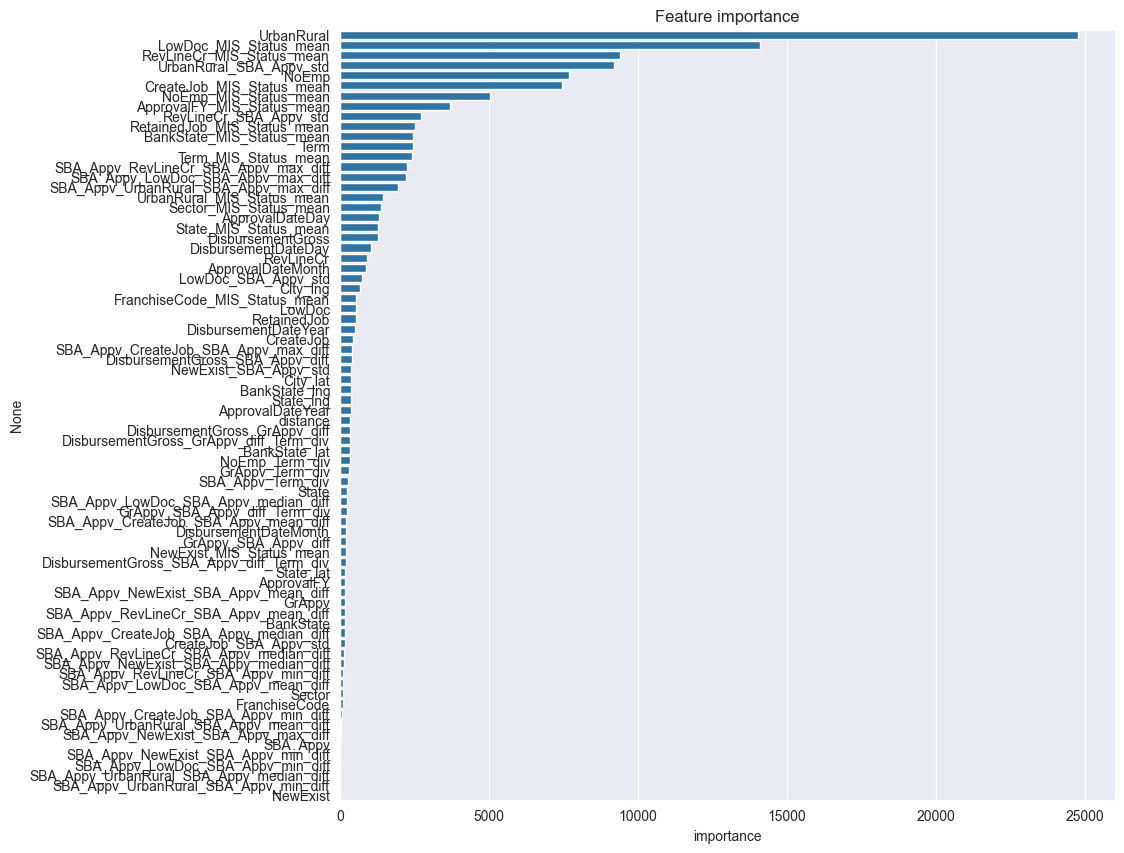

In [33]:
feature_importance_list = np.zeros(len(model.feature_importances_), dtype=np.float32)
for model_list_ in model_list:
    for model in model_list_[:10]:
        feature_importance_list += model.feature_importances_
    # 特徴量重要度を表示する
    importance = pd.DataFrame(model.feature_importances_, index=train_df.drop([target_col,"fold"]).columns, columns=['importance'])
    # グラフ化
    plt.figure(figsize=(10, 10))
    sns.barplot(x='importance', y=importance.sort_values('importance', ascending=False).index, data=importance.sort_values('importance', ascending=False))
    plt.title('Feature importance')
    plt.show()

In [34]:
test_proba_list = []
for model_list_ in model_list:
    test_proba = np.zeros((len(test_df), 2), dtype=np.float32)
    for model in model_list_[:10]:
        test_proba += model.predict_proba(test_df.to_numpy())
    test_proba_list.append(test_proba)

test_proba = test_proba_list[0]
max_indices = np.argmax(test_proba, axis=1)

# index_listとmax_indices持つデータフレームを作成
_ = pd.read_csv(f'{DATA_PATH}/test.csv')
submission_df = pd.DataFrame({'id': _["Unnamed: 0"].to_list(), target_col: max_indices})

submission_df.to_csv(f'{OUTPUT_PATH}/{EXP_DIR}_{score}.csv', index=False, header=False )

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ogurayuudai/Library/CloudStorage/GoogleDrive-yudai.otahigh@gmail.com/マイドライブ/signate/finance_2/input_data/test.csv'

In [ ]:
submission_df[target_col].value_counts()